##Workflow steps
1. Getting data
2. build model
3. fit model to data
4. make predictions and evaluate model (inference)
5. saving and loading a model
6. Put it all together

In [1]:
steps = {
    1: "Getting data",
    2: "Build Model",
    3: "Fit model to data",
    4: "Make predictions and evaluate model (inference)",
    5: "Saving and loading a model"
}
steps

{1: 'Getting data',
 2: 'Build Model',
 3: 'Fit model to data',
 4: 'Make predictions and evaluate model (inference)',
 5: 'Saving and loading a model'}

In [2]:
import torch
from torch import nn # neural network building blocks
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

##Machine Learning Oversimplified
1. Get represent all types of data as numbers
2. build a model that learns patterns from that representation


In [3]:
#training a model with already known data, in this case use linear regression as a example


weight = 0.5
bias = 0.4

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #remember unsqueeze adds a dimension, and we can add the dimension as dim=0 so adding a
y = weight * X + bias #so we're setting y to the result of multiplying weight against all scalar values of X, our tensor, and adding the bias.
#X is our input and y is out output, where y represent the linear regression formula

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.4000],
         [0.4100],
         [0.4200],
         [0.4300],
         [0.4400],
         [0.4500],
         [0.4600],
         [0.4700],
         [0.4800],
         [0.4900]]),
 50,
 50)

## Splitting Data into training and test sets


In [4]:
#We can split data into training, validation, and testing sets. validation tests you can think of as mock/practice exams and test sets are the actual exam.
# Validation sets are not necessart


train_split = int(0.8* len(X)) #should evaluate to 40, so it will serve as our index
X_train,y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
#use simple splicing using the index we received
print(len(X_train), len(y_train), len(X_test), len(y_test))


40 40 10 10


##Visualizing the data using matplotlib

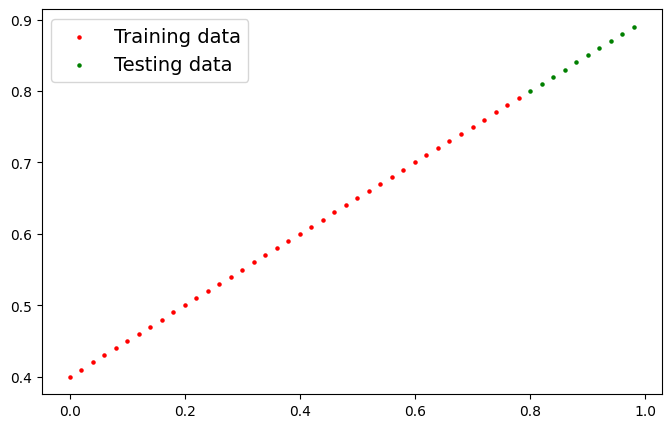

In [5]:
def plot_prediction(train_data = X_train,
                    train_labels =  y_train,
                    test_data = X_test,
                    test_labels=y_test,
                    predictions=None):
  """
  Plots training and test data as well as compares predictions.
  """
  plt.figure(figsize=(8,5))

  #Plot training data red
  plt.scatter(train_data, train_labels, c="red", s=5, label="Training data")

  #Plot test data in yellow
  plt.scatter(test_data, test_labels, c="g", s=5, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='blue', s=5, label="Predictions")

  plt.legend(prop={"size":14})

plot_prediction()


##Linear Regression Model

In [6]:
from torch import nn
class LinearRegressionModel(nn.Module): #it is the base class for nn modules so models should be a subclasss of nn.Modules, we can also nest modules in like trees.
  def __init__(self):
    super().__init__() #super allows us to access the parent class nn.Module as LinearRegression is the parent class.


    #we assign the model parameters
    self.weights = nn.Parameter(torch.randn(1, #these are the scalar weights, the 'neurons', so it's just 1 random scalar value
                                            requires_grad=True, #this is to tell pytorch to turn on it's Autograd engine that stores gradients for gradient descent and backpropagation
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

    #forward refers to the forward propagation, so at the end of the day the 'calculation'
  def forward(self,x:torch.Tensor) -> torch.Tensor: #remember -> is a function return annotation, therefore the function returns a torch.tensor
    return self.weights * x + self.bias #this just returns the linear regression formula


In [7]:
torch.manual_seed(42) #create manual seed so that we can track how training works for now
#Different ways to visualize nn parameters
model0 = LinearRegressionModel()
print(list(model0.parameters()))
print(model0.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})


In [8]:
print(X_test, '\n',y_test)

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]]) 
 tensor([[0.8000],
        [0.8100],
        [0.8200],
        [0.8300],
        [0.8400],
        [0.8500],
        [0.8600],
        [0.8700],
        [0.8800],
        [0.8900]])


In [9]:
#Running a model through inferece
with torch.inference_mode():
  y_prediction = model0(X_test)

y_prediction

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

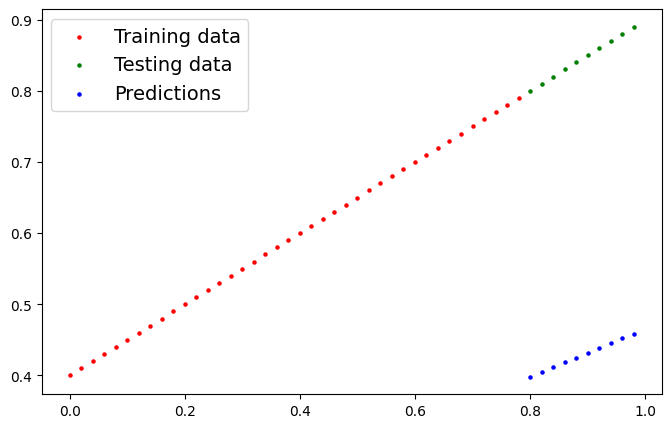

In [10]:
plot_prediction(predictions=y_prediction)

##Training Loops and Testing Loops

In [11]:
##We need a loss function for our model to learn https://docs.pytorch.org/docs/stable/nn.html#loss-functions

loss_fn = torch.nn.L1Loss()


##We also need a optimizer to work with the loss function  like SGD as an algorithm https://docs.pytorch.org/docs/stable/optim.html

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01) #we must give it the model parameters and the lr. The lr is a hyperparameter that we set, we decide how much the model 'learns' per iteration


##Here's what happens during a training loop
0. Loop through data
1. Forward propagation of data
2. calculate loss
3. optimizer zero grad
4. backpropagation
5. Adjust weights based on backpropagation algorithm using optimizer based on gradient (SGD)

In [12]:
##Here's the training loop
torch.manual_seed(42)
epochs = 100

epoch_count = []
loss_values = []
test_loss_values = []


for epoch in range(epochs):
  model0.train() #sets model to train mode, necessary to train models, it basically makes all parameters require gradients as gradients is what we use to move weights

  y_pred = model0(X_test) #1. forward propagation

  loss = loss_fn(y_pred, y_test) #2. calculate loss

  optimizer.zero_grad() #3 zeros the gradient as it is stored in memory and accumulates if we don't zero it. Therefore it could be any step before grad_descent

  loss.backward() #4. backpropagation

  optimizer.step() #5. grad_descent


  model0.eval()#this turns off train mode by 'disabling' gradients (so it makes requires_grad false in the parameters)

  with torch.inference_mode():
    #forward pass
    test_pred = model0(X_test)
    #calculate loss
    test_loss = loss_fn(test_pred,y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f'Epoch: {epoch} | Loss: {loss} | Test_Loss : {test_loss}')
#print(f'Loss {loss}')
print(model0.state_dict())

Epoch: 0 | Loss: 0.4165361821651459 | Test_Loss : 0.39861518144607544
Epoch: 10 | Loss: 0.2373262345790863 | Test_Loss : 0.21940524876117706
Epoch: 20 | Loss: 0.05811641365289688 | Test_Loss : 0.04019543528556824
Epoch: 30 | Loss: 0.013567489571869373 | Test_Loss : 0.004353475756943226
Epoch: 40 | Loss: 0.013567489571869373 | Test_Loss : 0.004353475756943226
Epoch: 50 | Loss: 0.013567489571869373 | Test_Loss : 0.004353475756943226
Epoch: 60 | Loss: 0.013567489571869373 | Test_Loss : 0.004353475756943226
Epoch: 70 | Loss: 0.013567489571869373 | Test_Loss : 0.004353475756943226
Epoch: 80 | Loss: 0.013567489571869373 | Test_Loss : 0.004353475756943226
Epoch: 90 | Loss: 0.013567489571869373 | Test_Loss : 0.004353475756943226
OrderedDict({'weights': tensor([0.5503]), 'bias': tensor([0.3688])})


/tmp/ipython-input-3257532984.py:3: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label='Train Loss')


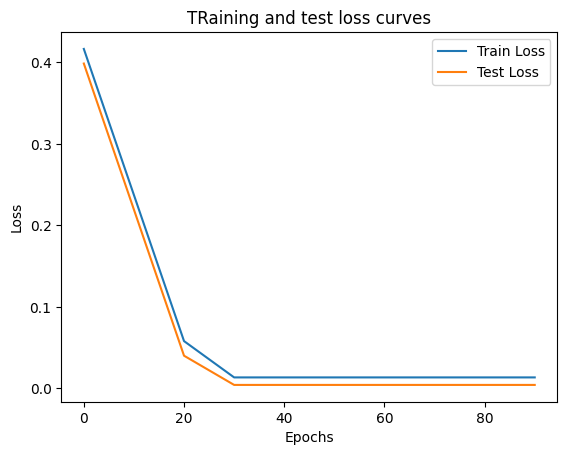

In [13]:
##Plot the loss
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label='Train Loss')
plt.plot(epoch_count,test_loss_values,label='Test Loss')
plt.title('TRaining and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [14]:
weight,bias

(0.5, 0.4)

In [15]:
model0.state_dict() #state of parameters before training loop, do not rerun

OrderedDict([('weights', tensor([0.5503])), ('bias', tensor([0.3688]))])

In [16]:
with torch.inference_mode():
  y_preds_new = model0(X_test)

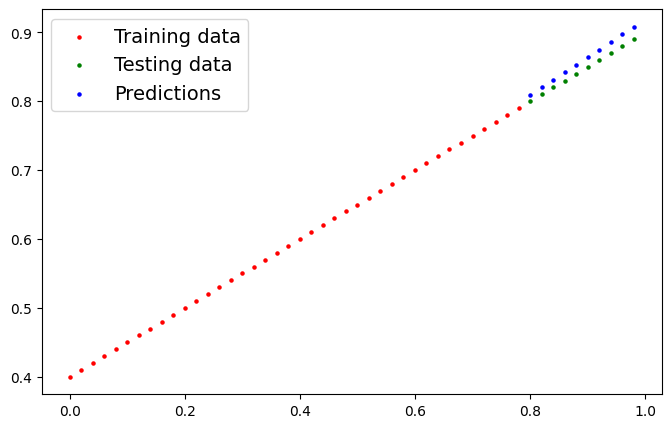

In [17]:
plot_prediction(predictions=y_preds_new)

##Saving Models
3 main methods

1. torch.save() - to save pytorch objects in pytorch pickle formats (binary protocols for serializing and deserializing python objects
2. torch.load() - allows loading a saved pytorch object
3. torch.nn.Module.load_state_dict()- saved a model's saved state dictionary


In [18]:
from pathlib import Path

#create model directory
Model_path = Path('models')
Model_path.mkdir(parents=True, exist_ok=True)

#create save path
Model_Name = '01_pytorch_workflow_model0.pth'
Model_save_path = Model_path / Model_Name

#save the model state dict
print(f'Saving to {Model_save_path}')
torch.save(obj=model0.state_dict(),
           f=Model_save_path)


Saving to models/01_pytorch_workflow_model0.pth


In [19]:
##Loading a Model
#create a new instance
Loaded_model = LinearRegressionModel()
Loaded_model.load_state_dict(torch.load(f=Model_save_path))
#Loaded_model(X_test) == model0(X_test)
with torch.inference_mode():
  y_pred_1 = Loaded_model(X_test)
  y_pred_2 = model0(X_test)
print(y_pred_1,'\n', y_pred_2)

tensor([[0.8090],
        [0.8200],
        [0.8311],
        [0.8421],
        [0.8531],
        [0.8641],
        [0.8751],
        [0.8861],
        [0.8971],
        [0.9081]]) 
 tensor([[0.8090],
        [0.8200],
        [0.8311],
        [0.8421],
        [0.8531],
        [0.8641],
        [0.8751],
        [0.8861],
        [0.8971],
        [0.9081]])


In [20]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__


'2.9.0+cu126'

In [21]:
#device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [22]:
#Data creation
weight = 0.5
bias = 0.1

#create a range of values
start = 0
end = 1
step = 0.02

#create features

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.1000],
         [0.1100],
         [0.1200],
         [0.1300],
         [0.1400],
         [0.1500],
         [0.1600],
         [0.1700],
         [0.1800],
         [0.1900]]))

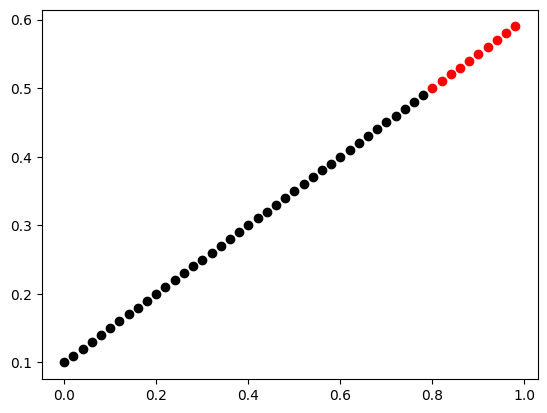

In [23]:
#slit data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
#80% for training, 20 for tests

plt.scatter(X_train,y_train, c='black',label='Train Data')
plt.scatter(X_test,y_test, c='red',label='Test Data')

In [24]:
#make a model
class LinearV2(nn.Module):
  def __init__(self):
    super().__init__()
    #we can use nn.Linear() to create model parameters
    self.linear_layer = nn.Linear(in_features=1, #in and outfeatures are the mappings, say for color we could have 3 in features and 3 out features etc
                                  out_features=1) #nn.Linear applies linear transformation on data
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(43)
model1 = LinearV2()
model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.0921]])),
             ('linear_layer.bias', tensor([-0.6070]))])

In [25]:
#check devices
next(model1.parameters()).device
model1.to(device)

LinearV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [29]:
#training, set a loss function and backpropagation algorithm
torch.manual_seed(43)
loss_fun = nn.L1Loss() # Instantiate the loss function by adding parentheses
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.01)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 200 # Revert epochs to original value
epoch_range = []
loss_values = []

for epoch in range(epochs):
  model1.train()#set to train mode
  y_preds = model1(X_train) # get preds for X_train
  loss = loss_fun(y_preds, y_train) # calculate loss value comparing y_preds with y_train
  optimizer.zero_grad() #zero the gradient
  loss.backward() #backpropagate
  optimizer.step() #take a step towards where the gradient converges
  ## testing
  model1.eval()
  with torch.inference_mode():
    test_pred = model1(X_test)
    test_loss = loss_fun(test_pred, y_test)
  if epoch % 10 == 0: # Revert print frequency to original value
    epoch_range.append(epoch)
    loss_values.append(loss)
    print(f'Epoch : {epoch} | train_loss : {loss} | test_loss : {test_loss}')

Epoch : 0 | train_loss : 0.021894661709666252 | test_loss : 0.0018555372953414917
Epoch : 10 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 20 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 30 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 40 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 50 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 60 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 70 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 80 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 90 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 100 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 110 | train_loss : 0.004537520930171013 | test_loss : 0.004375332500785589
Epoch : 120 | 

In [30]:
print(f'answers: {weight, bias}')

answers: (0.5, 0.1)


In [31]:
#test result
model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5091]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.1010], device='cuda:0'))])

In [32]:
#evaluating
model1.eval()
with torch.inference_mode():
  y_preds2 = model1(X_test)
y_preds2

tensor([[0.5083],
        [0.5185],
        [0.5286],
        [0.5388],
        [0.5490],
        [0.5592],
        [0.5694],
        [0.5796],
        [0.5897],
        [0.5999]], device='cuda:0')

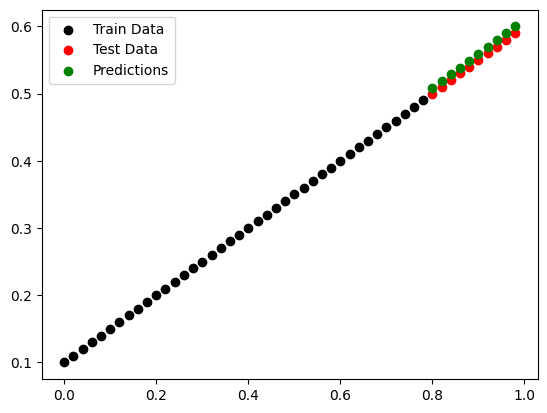

In [39]:
plt.scatter(X_train.cpu(), y_train.cpu(), c='black', label='Train Data')
plt.scatter(X_test.cpu(), y_test.cpu(), c='red', label='Test Data')
plt.scatter(X_test.cpu(), y_preds2.cpu(), c='green', label='Predictions')
plt.legend()

In [46]:
from pathlib import Path

model_path = Path('models')
model_path.mkdir(parents=True,exist_ok=True)

model_name = 'model1.pth'
model_save_path = model_path/model_name
#model_save_path

torch.save(obj=model1.state_dict(),
           f=model_save_path)

In [52]:
model1V2 = LinearV2()
model1V2.to(device)
model1V2.load_state_dict(torch.load(f=model_save_path))
with torch.inference_mode():
  ypred1 = model1(X_test)
  ypred2 = model1V2(X_test)

print(ypred1 == ypred2)
print(model1.state_dict(), model1V2.state_dict())


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')
OrderedDict({'linear_layer.weight': tensor([[0.5091]], device='cuda:0'), 'linear_layer.bias': tensor([0.1010], device='cuda:0')}) OrderedDict({'linear_layer.weight': tensor([[0.5091]], device='cuda:0'), 'linear_layer.bias': tensor([0.1010], device='cuda:0')})
